# <center> Домашняя работа 1.3

### Ставится задача классификации текстов на написанных депрессивным или не депрессивным человеком.  

In [1]:
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 6,3
pd.set_option('display.max_columns', 100)
data = pd.read_csv('train.csv', sep='\t')

### Предобработаем данные. 

In [2]:
import pymorphy2
from nltk.tokenize import word_tokenize

class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

morpher = MorphProvider()

from tqdm import tqdm

data["normalized"] = [morpher.morph_string(t) for t in tqdm(data.text)]

100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:02<00:00, 86.31it/s]


In [3]:
data["normalized_words"] = data.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

In [4]:
morph = pymorphy2.MorphAnalyzer()

In [5]:
bad_words = ['социофобия', 'депрессия', 'боль', 'страх', 'ненависть',
             'ужас', 'боюсь', 'ужасный',
             'ненавидимый', 'презираемый', 'противный', 'болезнь',
             'обессилен', 'депрессивный', 'грустно', 'боялся', 'бояться',
             'тревога', 'болеть', 'плохо', 'смерть', 'тоска', 'неприятно','диагноз',
             'больным','Дискомфорт', 'грустный', 'необщительный', 'социопат']

In [6]:
i = 0
dict_bad_words = {}
for word in bad_words:
    i = 0
    while i < 221:
        if morph.parse(word)[0].normal_form in\
        data.normalized_words[i].replace('!', '')\
                                .replace('?', '').replace('.', '').replace(',', '')\
                                .replace('–','').replace('.','').split():
            try:
                dict_bad_words[i] += 1
                #print(data.iloc[i][1])
            except:
                dict_bad_words[i] = 1
                #print(data.iloc[i][1])
        i += 1

In [7]:
good_words = ['радость', 'круто', 'счастье', 'улыбка', 'жизнь',
             'нравится', 'приятно', 'красивый',
             'любить', 'милый', 'здоровье', 'депрессивный', 'радостно', 'гордость', 'воля',
             'свобода', 'хорошо', "суицидальных", '']

In [8]:
i = 0
dict_good_words = {}
for word in good_words:
    i = 0
    while i < 221:
        if morph.parse(word)[0].normal_form in\
        data.normalized_words[i].replace('!', '')\
                                .replace('?', '').replace('.', '').replace(',', '')\
                                .replace('–','').replace('.','').split():
            try:
                dict_good_words[i] += 1
                #print(data.iloc[i][1])
            except:
                dict_good_words[i] = 1
                #print(data.iloc[i][1])
        i += 1

In [9]:
bad_words_column = np.zeros(len(data))
for key, value in dict_bad_words.items():
    bad_words_column[key] = value

good_words_column = np.zeros(len(data))
for key, value in dict_good_words.items():
    good_words_column[key] = value
    
lens = []
for i in range(0, len(data)):
    lens.append(len(data.iloc[i, :].text))

In [10]:
data['lens'] = lens

In [11]:
import re
split_regex = re.compile(r'[.|!|?|…]')

number_sentensens = []
sentensens_mean_len = []
words_number = []
words_mean_len = []

for i in range(0, len(data)):
    number_sentensens.append(len(list(filter(lambda t: t, [t.strip() for t in split_regex.split(data.text[i])]))))
    sentensens_mean_len.append(len(''.join(split_regex.split(data.text[i])))/len(list(filter(lambda t: t, [t.strip() for t in split_regex.split(data.text[i])]))))
    words_number.append(len(data.text[0].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))
    words_mean_len.append(len(''.join(data.text[0].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))/len(data.text[0].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))  

In [12]:
# std = data[['lens','label']].groupby('label').std()['lens']
# std_list = []
# for diag in data.label: 
#     if diag == 'Depression':
#         std_list.append(std[0])
#     else:
#         std_list.append(std[1])
# data['std'] = std_list

### Используем bag-of-words в качестве признаков.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['normalized_words']).toarray()
y = (data['label'] == 'Depression').astype(int)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

X_all = TfidfTransformer(use_idf=False).fit_transform(X)
X_all.shape

(221, 6301)

In [15]:
feature_names = vectorizer.get_feature_names()

In [16]:
X_all = pd.DataFrame(X_all.toarray())

### Добавим новые фичи.

In [17]:
X_all['bad_words'] = bad_words_column
X_all['good_words'] = good_words_column

In [18]:
X_all['lens'] = lens
X_all['lens_n'] = data[['lens']]/data[['lens']].sum()[0]
X_all['dif_med'] = abs(data['lens'] - data['lens'].median())
X_all['dif_mean'] = abs(data['lens'] - data['lens'].mean())
X_all['number_sentensens'] = number_sentensens
X_all['sentensens_mean_len'] = sentensens_mean_len
X_all['words_mean_len'] = words_mean_len
X_all['words_number'] = words_number
#X_all['std'] = data['std']

In [19]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X=X_all, y=y)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=220)

ppl = pca.fit_transform(X)

pca.explained_variance_ratio_.sum()

0.9999999999999998

(-5, 5)

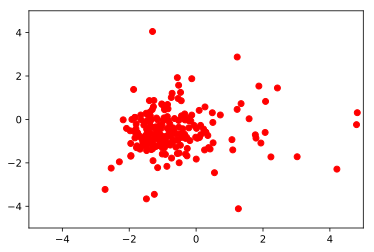

In [21]:
plt.plot(ppl[:,0], ppl[:,1], 'ro', alpha=1)
plt.ylim(-5,5)
plt.xlim(-5,5)

### Будем использовать xgboost в качестве нашего классификатора.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
import xgboost
clf = xgboost.XGBClassifier(
                            max_depth=5,
                            n_jobs=-1,
                            n_estimators=100,
                            min_samples_split=200,
                            learning_rate=0.079,
                            max_features='log2',
                            subsample=0.6578947368421052
)

clf.fit(X=X_train, y=y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
y_test_predict = clf.predict_proba(X_test)[:, 1]
# y_train_predict = clf.predict(X_train)
# y_test_predict = clf.predict(X_test)

In [24]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 9)

print("Train: ", round(roc_auc_train, 9))
print("Test: ", round(roc_auc_test, 9))

Train:  1.0
Test:  0.898989899


In [25]:
roc_auc_score(y_test, clf.predict(X_test))

0.8333333333333333

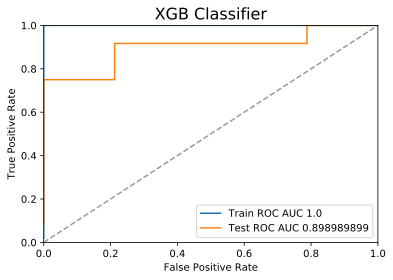

In [26]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

### Таким образом мы обучили модель с метрикой ROC_AUC равной 90% и с 83% процентами правильных предсказаний на тестовой выборке. 

In [28]:
scores = cross_validate(
    clf, X, y, cv=4, scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall'), return_train_score=True
)
scores

{'fit_time': array([1.79120684, 1.76727152, 1.81813598, 2.15423608]),
 'score_time': array([0.05186129, 0.05186129, 0.05385613, 0.06582332]),
 'test_accuracy': array([0.91071429, 0.80357143, 0.87272727, 0.83333333]),
 'test_f1': array([0.83870968, 0.64516129, 0.74074074, 0.57142857]),
 'test_precision': array([0.86666667, 0.66666667, 0.90909091, 1.        ]),
 'test_recall': array([0.8125, 0.625 , 0.625 , 0.4   ]),
 'test_roc_auc': array([0.8875    , 0.8484375 , 0.91185897, 0.90769231]),
 'train_accuracy': array([1., 1., 1., 1.]),
 'train_f1': array([1., 1., 1., 1.]),
 'train_precision': array([1., 1., 1., 1.]),
 'train_recall': array([1., 1., 1., 1.]),
 'train_roc_auc': array([1., 1., 1., 1.])}

In [29]:
rcParams['figure.figsize'] = (10, 15)
clf.feature_importances_

array([0.        , 0.        , 0.        , ..., 0.00227273, 0.        ,
       0.        ], dtype=float32)

### Выведем самые важные фичи.

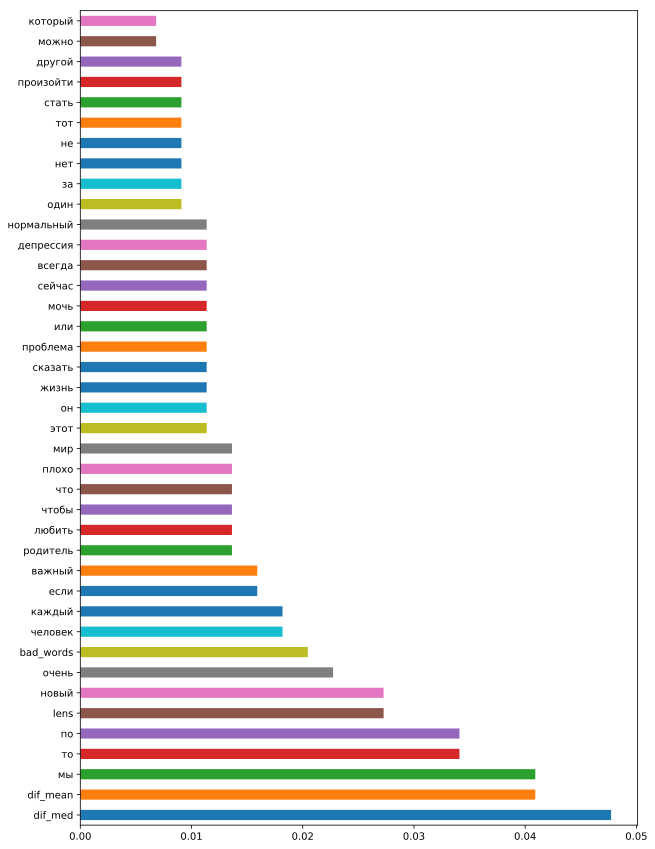

In [59]:
# xgboost.plot_importance(booster=clf)
IDcol = 'ID'
y_label = 'label'
predictors = [x for x in X_all.columns if x not in [y_label, IDcol]]

names = []
for i in predictors:
    try:
        names.append(feature_names[int(i)])
    except:
        names.append(i)

(pd.Series(clf.feature_importances_, names).sort_values(ascending=False))[:40].plot(kind='barh')

In [31]:
# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[10]
#     }

In [32]:
# %%time
# param_test1 = {'n_estimators':range(0,250,50)}
# gsearch1 = GridSearchCV(estimator = clf, param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch1.fit(X,y)

In [33]:
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [34]:
# %%time
# param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
# gsearch2 = GridSearchCV(estimator = clf, param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch2.fit(X,y)

In [35]:
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [36]:
# %%time
# param_test3 = {'learning_rate': np.linspace(0, 0.1, 20)}
# gsearch3 = GridSearchCV(estimator = clf, param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch3.fit(X,y)

In [37]:
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [38]:
# %%time
# param_test4 = {"max_features":np.linspace(0, 30, 10)}
# gsearch4 = GridSearchCV(estimator = clf, param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch4.fit(X,y)

In [39]:
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [40]:
# %%time
# param_test5 = {"subsample":np.linspace(0.5, 0.7, 20)}
# gsearch5 = GridSearchCV(estimator = clf, param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch5.fit(X,y)

In [41]:
# gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [42]:
# %%time
# param_test6 = {"gamma":np.linspace(0, 1, 8)}
# gsearch6 = GridSearchCV(estimator = clf, param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch6.fit(X,y)

In [43]:
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [44]:
# from sklearn.externals import joblib

# joblib.dump(clf, 'clf_depression.pkl', compress=1)